## python绘制colormap初探

- 汪星宇
- 2021年12月25日

为了直观地显示点云配准的结果, 常见的可视化手段是引入`colormap`, 有些地方也把图例的条带叫`colorbar`. 中文可以叫做**色彩映射**或者**色谱图**.
下面是*gom inspect*软件中配准结果的一个样例, 这里隐藏了colorbar.

<img src="../media/gom_colormap.jpg" alt="gom colormap 示意图" width = 800>

`colormap` 是一个常见的需求, 我将尝试利用`matplotlib`, `open3d`, `vtk`, `pyqtgraph`等实现它.

### 1. `matplotlib`中的`colormap`
#### 1.1. 基本的`colorbar`显示
官方的参考链接[Customized Colorbars Tutorial](https://matplotlib.org/stable/tutorials/colors/colorbar_only.html)
对应的函数名叫做`<Figure>.colorbar`, 传入**色彩映射**和**坐标轴**, colorbar可以设置连续的, 离散的, 也可以是任意长度的离散区间.

`matplotlib.cm.ScalarMappable`用于生成`colormap`对应的色彩映射

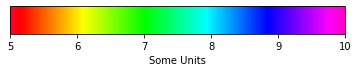

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import numpy as np
# 显示负号
matplotlib.rcParams['axes.unicode_minus']=False

def PlotColorbar(cmap, Range=[0, 1], label='Some Units'):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    norm = mpl.colors.Normalize(vmin=Range[0], vmax=Range[1])    # 归一化显示
    Colorbar = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(Colorbar, cax=ax, orientation='horizontal', label=label)

# matplotlib提供了 众多可选的色彩风格
# cmap = mpl.cm.hsv
cmap = mpl.cm.gist_rainbow          # 色彩风格
Range = [5, 10]             # 坐标范围
PlotColorbar(cmap, Range)

#### 1.2. 自定义的`colorbar`
`colorbar`的本质是**RGBA**色彩和**归一化数值**之间的映射, 因此可以较为方便地自行定义色彩映射.
在`matplotlib`中, 只需要传入不同的参数, 可以自定义任意的色彩映射.

- 利用内置`matplotlib.cm.get_cmap(name=None, lut=None)`, 获得`matplotlib.colors.ListedColormap`, 并改变其中的值

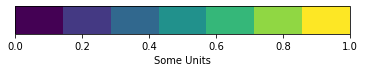

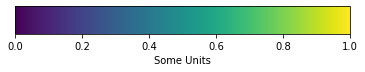

In [2]:
# 粗糙离散的色彩
c7 = mpl.cm.get_cmap('viridis', 7)
PlotColorbar(c7)

# 密集的色彩映射采样
c4096 = mpl.cm.get_cmap('viridis', 4096)
PlotColorbar(c4096)

- 使用`matplotlib.colors.ListedColormap(colors, name='from_list', N=None)`生成颜色映射, 传入`list`或`array`格式的*RGB*或*RGBA*数组

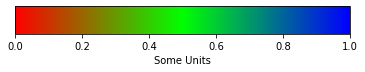

In [3]:
# numpy 生成归一化数组
one2zero = np.linspace(1, 0, 128)
zero = np.zeros((128))
zero2one = np.flip(one2zero)
R = np.concatenate([one2zero, zero[1:]]).reshape([-1,1])
G = np.concatenate([zero2one, one2zero[1:]]).reshape([-1,1])
B = np.concatenate([zero, zero2one[1:]]).reshape([-1,1])

RGBArray = np.array(np.concatenate([R, G, B], axis=1))      # 三色数组拼接
Red_Green_Blue = mpl.colors.ListedColormap(RGBArray)

PlotColorbar(Red_Green_Blue)

但看起来结果和gom软件的色谱并不相同, 也许应该从提供的风格中截取.
尽管原始的风格并不相同, 但是通过截取恰当的长度之后, 得到的`colorbar`看起来完全一致.

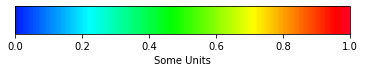

In [4]:
# 从'gist_rainbow'提取色谱
rainbowColor = mpl.cm.get_cmap('gist_rainbow')
rainbowColortemp = rainbowColor(np.linspace(0.75, 0, 256))  # 数值映射
GomColorBar = mpl.colors.ListedColormap(rainbowColortemp)

PlotColorbar(GomColorBar)

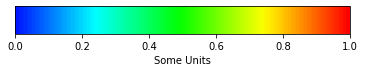

In [5]:
# 从'hsv'提取色谱
hsvColor = mpl.cm.get_cmap('hsv')
hsvColortemp = hsvColor(np.linspace(2/3, 0, 256))   # 数值映射
GomColorBar = mpl.colors.ListedColormap(hsvColortemp)

PlotColorbar(GomColorBar)

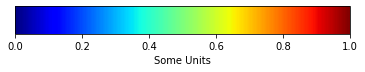

In [6]:
# jet 并不太像
PlotColorbar(mpl.cm.jet)

#### 1.3. 绘制带有`colorbar`的3D图形实例
常规的带有色彩映射的三维图像, 其`colorbar`的绘制主要是针对某一轴的, 比如`z轴`高度的色彩映射, 在点云配准中并不适用.

下面展示的是采用`plot_surface`中的`facecolors`参数的例子, 给每一片表面提供不同的色彩映射, 其原理还是对色彩进行数值索引.

[Colorbar for matplotlib plot_surface using facecolors](https://stackoverflow.com/questions/42924993/colorbar-for-matplotlib-plot-surface-using-facecolors) 这里给出了具有高度信息的三维*surface*的色彩映射指导.

- 使用`facecolors`, 参数数量不少于`face`的数量, 可以多不会报错


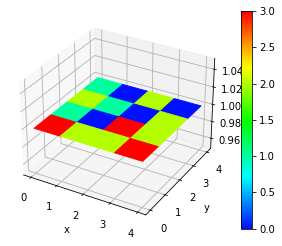

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

# 3d图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 点坐标 -> 网格
x = np.arange(5)
X,Y = np.meshgrid(x,x)
Z = np.ones_like(X)

# 色彩参数信息, norm 归一化  4*4的面
V = np.array([[3,2,2,3 ],[1,0,3,2],[2,1,0,2], [1,0,2,0] ])
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
ax.plot_surface(X, Y, Z, facecolors=GomColorBar(norm(V)), shade=False)

m = cm.ScalarMappable(cmap=GomColorBar, norm=norm)
m.set_array([])
plt.colorbar(m)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

`matplotlib`所提供的`colorbar`和`colormap`能够较为方便地解决很多二维和三维显示上的问题, 但是并不非常适用于点云格式文件, 因此没有进一步使用其做点云配准结果展示.

不过我们之前创建的`GomColorBar`, 可以方便地迁移到别的环境中去.

### 2. `Open3D`中的`colormap`
通过索引`GomColorBar`的色彩, 对`<Open3D.geometory.PointCloud>.colors`进行一一赋值, 可以得到对应的`colormap`, 示意图如下.

<img src="../meida/open3d_colormap.png" alt="Open3D中显示colormap" width = 750 />

在`Open3D`中的显示`colormap`仍然存在的一些重要问题如下:

- [ ] 尽管可以绘制`colormap`, 但Open3D无法插入`colorbar`
- [ ] 尽管可以计算ICP或者任意其他的匹配误差, 但是仅能获得*误差绝对值*, 不能体现偏差的正负. 也许可以通过计算并引入点云的法向量解决
- [ ] 尽管可以显示点云`PointCloud`的误差映射, 但对于stl文件模型的`Mesh`格式数据, 其色彩映射是以面的形式呈现的, 如果通用是色彩索引那就需要计算面和面的距离; 不过如果精度要求不高, 也许可以通过面的顶点近似.

### 3. `VTK`中的`colormap`

下一步工作
